In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from myst_nb import glue
from slugify import slugify

from plastockconf import name_zones, name_frequentation, name_situation
from plastockconf import name_substrate, name_distance, table_css_styles

from plastock import add_table_to_page, capitalize_x_tick_labels, capitalize_x_and_y_axis_labels, capitalize_legend_components, attribute_summary

import reportclass as rc
import setvariables as conf_


import matplotlib as mpl


format_kwargs = dict(precision=2, thousands="'", decimal=",")
def make_exportable(data, file_name, cmap='YlOrBr'):
    data.fillna(0, inplace=True)
    fig, ax = plt.subplots(figsize=(12,8))
    sns.heatmap(data=data, vmin=0, vmax=1, cmap=cmap, annot=True, fmt='.2', annot_kws={'size':10}, ax=ax, cbar=False)
    plt.tight_layout()
    ax.tick_params(which='both', axis='both', bottom=False, left=False)
    plt.savefig(file_name, dpi=300)

    plt.close()

glue('blank_caption', " ", display=False)

# Déchets Sauvages

Les déchets sauvages sur les plages du Lac Léman font l'objet d'une surveillance depuis 2015. La campagne la plus récente avant Plastock a été parrainée par l'Office fédéral de l'environnement (OFEV) de 2020 à 2021. Les directives européennes sur la surveillance des déchets sauvages sur les plages ont été publiées en 2013 [Guidance on Monitoring Marine Litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf). Les méthodes utilisées pour surveiller les déchets sauvages sur le lac Léman suivent les directives de l'UE, tout en tenant compte des contraintes liées aux différences de topographie entre le littoral maritime et le littoral lacustre.

## Le système de mesure.

Les déchets sauvages sur les plages sont mesurés en unités de déchets par mètre linéaire de rivage. Les relevés sont effectués entre la ligne d'eau (là où l'eau et la terre se rejoignent) et la ligne de dérive (la distance la plus éloignée de la ligne d'eau atteinte par les vagues). Cette méthode a été adoptée dès le début en Suisse, ce qui signifie que les 250 échantillons précédents du lac Léman ont été collectés et mesurés selon la méthode précédemment décrite.

__Dans cette section, les unités sont des déchets par mètre de rivage: (pcs/m)__

### Exigences particulières données plastock

La quantité de déchets sauvages par mètre de plage correspond au nombre total d'objets identifiés divisé par la longueur du rivage. Pour les données Plastock, cela signifie que nous devons considérer la position un (ligne d'eau) et la position deux (plage sèche) ensemble. De plus, il y a __douze échantillons où le substrat était différent entre la position un et la position deux__. Par conséquent, ces 12 échantillons ont tous été classés dans la catégorie Sables grossiers.

In [2]:
new_data = pd.read_csv("data/end_pipe/macro_current.csv")
beach_data = pd.read_csv("data/pstock_beaches_current.csv")
codes = pd.read_csv('data/end_pipe/codes.csv').set_index('code')

new_column_names = {
    "Position":"position",
    "Substrat":"substrat",
    "Date":"date",
    "Code":"code",
    "Quantité":"quantité",
    "Aire":"area"
}

length_key = beach_data[["Plage","length"]].drop_duplicates("Plage").set_index("Plage")
work_data = new_data[["Plage", *new_column_names.keys()]].copy()
work_data.rename(columns=new_column_names, inplace=True)
work_data["length"] = work_data.Plage.apply(lambda x: length_key.loc[x, "length"])
work_data["slug"] = work_data.Plage.apply(lambda x: slugify(x))
work_data["echantillon"] = list(zip(work_data.slug, work_data['date']))
work_data['date'] = pd.to_datetime(work_data["date"], format="mixed", dayfirst=True)
work_data.dropna(inplace=True)
work_data[["position", "substrat"]] = work_data[["position", "substrat"]].astype("int")
work_data['échantillon'] = work_data['echantillon']
work_data.drop(['echantillon'], inplace=True, axis=1)
work_data = work_data.groupby(['échantillon', 'Plage', 'substrat', 'date', 'length', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})
work_data['pcs/m'] = work_data['quantité']/work_data['length']


voi = 'substrat'
vals = "pcs/m"
some_data = work_data.copy()
groupby = ['échantillon', voi]
data = some_data.groupby(groupby, as_index=False)[vals].sum()
dd = data[data['échantillon'].duplicated()].copy()

# duplicates = work_data[work_data['échantillon'].isin(ddd)].copy()
duplicated = work_data[work_data['échantillon'].isin(dd['échantillon'].unique())].copy()
duplicated['substrat'] = 2 

# notduplicated
not_duplicated = work_data[~(work_data['échantillon'].isin(dd['échantillon'].unique()))].copy()

# put it back to gether again
work_data = pd.concat([duplicated, not_duplicated])
work_data = work_data.groupby(['échantillon', 'Plage', 'substrat', 'date', 'length', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})
work_data['pcs/m'] = work_data['quantité']/work_data['length']

# accounting for objects not found at a sample:
# the codes that were indentified
codes_ip = work_data.code.unique()
# the unique samples
loc_dates = work_data['échantillon'].unique()

# a copy for itterating
wd = work_data.copy()

# for each sample (échantillon) indentify the codes that were not
# found by indentifying all the codes that were found in all surveys
# and removing the codes that were not identified at that sample.
# for each unidentified code per sample, add a row with the sample
# id and the code. give the row a quantity of zero.
rows = []
for a_loc in loc_dates:
    r = wd.loc[wd['échantillon'] == a_loc].copy()
    r.reset_index(inplace=True, drop=True)
    
    t = r.loc[0][['échantillon', 'Plage', 'substrat', 'date', 'length', 'slug']].values
    asamp = [x for x in t]
    used_codes = r.code.unique()
    unused = [x for x in codes_ip if x not in used_codes]
    for element in unused:
        arow = [*asamp, element, 0, 0]
        rows.append(arow)
        

work_x = pd.DataFrame(rows, columns=['échantillon', 'Plage', 'substrat', 'date', 'length', 'slug', 'code', 'quantité', 'pcs/m'])
work_data = pd.concat([work_x, work_data])

La distribution de la variable de substrat après la réattribution des 12 échantillons en question.

1. Sables fins : 27%
2. Sables Grossiers : 32%
3. Graviers : 16%
4. Cailloux : 25%

In [3]:
repartition_substrat = work_data.groupby('substrat')['échantillon'].nunique()/work_data['échantillon'].nunique()

In [4]:
new_names = {x: " " for x in work_data.columns}
new_names = {
    'échantillon': 'loc_date',
    'pcs/m': 'pcs_m'
}

change_names = ['preverenges', 'tolochenaz', 'versoix', 'vidy', 'cully']

changeus = work_data[work_data.slug.isin(change_names)].copy()
donotchange = work_data[~work_data.slug.isin(change_names)].copy()

new_slug = {
    'cully': 'cully-p',
    'preverenges': 'preverenges-p',
    'tolochenaz': 'tolochenaz-p',
    'versoix':'versoix-p',
    'vidy': 'vidy-p'}

# they have the same name as locations in iqaasl
changeus['new_slug'] = changeus.slug.apply(lambda x: new_slug[x])
changeus['slug'] = changeus.new_slug
changeus.drop('new_slug', inplace=True, axis=1)
wd_nn = pd.concat([changeus, donotchange])

# codes in the plastock data
pcodes = wd_nn.code.unique()

# identify and remove codes for which there is no defintion
t = [x for x in pcodes if x not in codes.index]
wd_ni = wd_nn[~wd_nn.code.isin(t)].copy()

# aggregate to grfags, gfoams, gcaps
ti = rc.use_gfrags_gfoams_gcaps(wd_ni, codes)

# aggregate along all land-use and topo variables.
ti = ti.groupby(['échantillon', 'Plage', 'date', 'substrat', 'length', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})

# make city map and format plastock data to work with report class
f = pd.read_csv('data/u_pstk.csv')
city_map = f[["slug", "city"]].drop_duplicates()
city_map.loc[city_map.slug == 'savoniere', 'slug'] = 'savonniere'
city_map.set_index('slug', inplace=True)

# adding and renaming columns according to reportclass requirements
ti['city'] = ti.slug.apply(lambda x: city_map.loc[x])
ti['feature_name'] = 'lac-leman'
ti['feature_type'] = 'l'
ti['parent_boundary'] = 'rhone'
ti.rename(columns={**new_names,'quantité': 'quantity'}, inplace=True)
ti['pcs_m'] = ti.quantity/ti.length


twork_cols = ['loc_date', 'date','slug', 'project',
       'code', 'quantity', 'city', 'feature_name', 'feature_type',
       'parent_boundary', 'pcs_m']

sing_cols = ['loc_date', 'date','slug', 'Plage', 'substrat',
       'code', 'quantity', 'city', 'feature_name', 'feature_type',
       'parent_boundary', 'pcs_m']
ti_work = ti[sing_cols].copy()

# previous results
ghi = pd.read_csv('data/end_pipe/iqaasl.csv')

ti_work['project']='Plastock'
# combine zones and substrat
# comb_cols = ['loc_date', 'date', 'slug',
#         'city','feature_name', 'feature_type',
#        'parent_boundary','code']


ti_work = ti_work.groupby(sing_cols, as_index=False).agg(conf_.unit_agg)
ti_work['project']='Plastock'
txi = pd.concat([ghi, ti_work[twork_cols ].copy()])
txi.reset_index(inplace=True)
txi = txi[txi.code.isin(ti_work.code.unique())]

language_maps = rc.language_maps()
boundaries = dict(start_date="2021-12-31", end_date="2023-01-01", feature_name="lac-leman", language="fr")
top_label= ['feature_name', 'lac-leman']

tiii = rc.ReportClass(ti_work.copy(), boundaries=boundaries, language="fr", lang_maps=language_maps, top_label=top_label)
header = tiii.a_short_description.fillna('.')
comp_summary = tiii.summarize_feature_labels(feature='feature_name')
most_common, weight = tiii.most_common

boundaries = dict(start_date="2019-12-31", end_date="2023-01-01", feature_name="lac-leman", language="fr")
combined = rc.ReportClass(txi.copy(), boundaries=boundaries, language="fr", lang_maps=language_maps, top_label=top_label)

## Situation

Les déchets sauvages ont été collectés dans 25 emplacements différents autour du Léman. Soixante-sept sur 98 de ces emplacements se trouvaient dans des zones urbaines, avec un taux d'utilisation élevé de 55 sur 98, et 83 sur 98 étaient situés à moins de 500 mètres d'un parking. Les caractéristiques ont été notées par les personnes chargées de la collecte des déchets sauvages [Macro déchets plage et attribut](macro-attributes).

### Les résultats

In [5]:
t = rc.translated_and_style_for_display(comp_summary.copy(),  tiii.lang_maps[tiii.language], tiii.language, gradient=False)
rep_res_one = "L'échantillonnage était planifié trimestriellement, commençant en janvier 2022. À quelques exceptions près, chaque emplacement était échantillonné quatre fois au cours de la période de 12 mois. Les études précédentes sur le lac étaient mensuelles ou aléatoires."
rep_res_two = "La médiane du total des échantillons était de 2 pièces/mètre avec une variance de 3,6 pièces/mètre."

glue('rep_results_one',rep_res_one , display=False)
glue('rep_results_two',rep_res_two , display=False)
glue('rep_results', t, display=False)

<style>
table th:first-of-type {
    width: 50%;
}
table th:nth-of-type(2) {
    width: 50%;
}

</style>


| |La répartition des résultats|
|:---:|:---|
|{glue}`rep_results`|<br>{glue:text}`rep_results_two`<br><br>{glue:text}`rep_results_one`|

In [6]:
comb_dt = tiii.w_df
comb_dt = comb_dt.groupby(['loc_date', 'date', 'project'], as_index=False).pcs_m.sum()

fig, ax = plt.subplots(2,2, figsize=(8,8))

sns.scatterplot(data=comb_dt, x="date", y="pcs_m", hue='project', ax=ax[0,0])
ax[0,0].set_title("Total par échantillon", loc="left")
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax[0,0].set_ylabel("")
capitalize_x_and_y_axis_labels(ax[0,0])
capitalize_legend_components(ax[0, 0])

sns.boxplot(data=comb_dt, y="pcs_m", x='project', hue='project', dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_title("Boîte de Tukey", loc="left")
capitalize_x_and_y_axis_labels(ax[0,1])
ax[0, 1].get_legend().remove()
ax[0,1].set_xlabel("")

sns.histplot(data=comb_dt, x="pcs_m", ax=ax[1,0], stat="probability", hue='project', kde=True)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_title("Histogramme", loc="left")
capitalize_x_and_y_axis_labels(ax[1,0])
ax[1, 0].get_legend().remove()

sns.ecdfplot(data=comb_dt, x="pcs_m", hue='project', ax=ax[1,1])
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])
sns.move_legend(ax[1, 1], title=" ", loc='best')

plt.subplots_adjust(wspace=.3, hspace=.3)

glue('fig-D1', fig, display=False)
plt.close()


```{glue:figure} fig-D1
---
name: fig-D1
---
{glue:text}`blank_caption` 
```

## Les objets les plus courants Plastock

### Définition des _objets les plus courants_

Les _objets les plus courants_ peuvent être sélectionnés de plusieurs manières. On peut également les appeler les _objets d'intérêt_. Dans le cadre de ce rapport, nous nous concentrons sur les objets qui représentent une proportion plus importante des résultats que les autres. Nous avons utilisé deux critères de sélection : i. la quantité, ii. le taux d'échec.

1. Quanité: Si un objet a une quantité totale qui le place dans les dix premiers, il est considéré comme 'courant'.
2. Taux d'échec: Si un objet a été trouvé dans au moins la moitié des échantillons, il est ÉGALEMENT considéré comme 'courant'.

Par conséquent, pour cette étude, les 'objets les plus courants' sont ceux qui se trouvent soit dans les dix premiers en termes de nombre total de pièces de déchets ET/OU qui ont été trouvés dans au moins 50% des enquêtes. Pour Plastock, les objets les plus courants représentent 89% du montant total ou 24'156/27'493.

```{note}
Les équipes peuvent avoir d'autres critères pour s'intéresser à l'occurrence d'un objet dans l'environnement. Il s'agit d'un sujet qui devrait être largement développé au sein des équipes. 
```

In [7]:
# pd.set_option('max_colwidth',50)
xi = rc.translated_and_style_for_display(most_common.copy(),  tiii.lang_maps[tiii.language], tiii.language, gradient=False)
xi.set_caption("Les objets les plus courants Plastock")
glue('mc_pstock', xi, display=False)

<!-- <style>
table th:first-of-type {
    width: 25%;
}
table th:nth-of-type(2) {
    width: 25%;
}
    table th:nth-of-type(3) {
    width: 25%;
}
    table th:nth-of-type(4) {
    width: 25%;
}

</style> -->


```{glue} mc_pstock
```

### Correspondance avec les résultats d'OSPAR

La Suisse et la France sont toutes deux parties contractantes de la convention [OSPAR](https://www.ospar.org/organisation/contracting-parties). Parmi les objets les plus courants identifiés à partir des données Plastock, six peuvent également être retrouvés dans le rapport d'état de qualité le plus récent d'OSPAR concernant l'Abondance, la Composition et les Tendances des [déchets sauvages](https://www.ospar.org/work-areas/eiha/marine-litter/assessment-of-marine-litter/beach-litter).

1. Fragments de plastique : g80, g79, g78, g77, g76, g75
2. Fragments de polystyrène expansé : g81, g82, g83
3. Couvercles en plastique de bouteille : g21, g22, g23, g24
4. Coton-tige
5. Emballages de bonbons, de snacks
6. Déchets de construction en plastique

```{note}
Les directives de surveillance d'OSPAR n'incluent pas les objets de moins de 5 mm. Par conséquent, des objets tels que les granulés industriels  (GPI) ou de petits morceaux de 5 mm ou moins ne figureront pas dans la liste des objets les plus courants d'OSPAR.

Selon le _Document de référence d'OSPAR sur les granulés plastiques pré-production_, [granulés OSPAR](https://www.ospar.org/documents?v=39764), entre 16 et 167 tonnes par an.
```

### Correspondance avec l'IQAASL

Les objets les plus courants répertoriés pour le lac Léman en 2021 comprennent tous les objets les plus courants de Plastock à l'exception des 'Fragments de plastique angulaires <5 mm', [Lac Léman, IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/).

```{note}
Les protections féminines et applicateurs de tampons, des éléments importants parmi les objets les plus courants d'OSPAR et d'IQAASL, n'ont pas été identifiées lors des enquêtes Plastock.
```

In [8]:
t = rc.a_cumulative_report(combined.w_df[combined.w_df.code.isin(most_common.index)], feature_name='project', object_column='code')
rc.translated_and_style_for_display(t, tiii.lang_maps[tiii.language], tiii.language, gradient=True).set_caption("Les objets les plus courants de Plastock et les résultats pour les mêmes objets de l'IQAASL")

,Iqaasl,Plastock,Cumulé
Fragments de plastique angulaires <5mm,"0,00","0,00","0,00"
Pellets industriels (gpi),"0,00","0,00","0,00"
Mégots et filtres à cigarettes,"0,47","0,15","0,30"
"Emballages de bonbons, de snacks","0,22","0,15","0,18"
Bâtonnets de sucette,"0,03","0,02","0,02"
Mousse de plastique pour l'isolation thermique,"0,10","0,00","0,02"
Déchets de construction en plastique,"0,06","0,00","0,00"
Coton-tige,"0,13","0,03","0,08"
"Couvercles en plastique bouteille: g21, g22, g23, g24","0,11","0,04","0,08"
"Fragments de polystyrène expansé: g81, g82, g83","0,24","0,07","0,11"


In [9]:
file_name = 'resources/images/most_common_iqaasl.jpg'
make_exportable(t, file_name)

### Les plus courants par ville

La densité médiane des objets les plus courants n'est pas la même pour chaque emplacement/municipalité, ce qui suggère une répartition géographiquement inégale de ces objets.

Résultats de Amphion à Hermance :

In [10]:
w_df = tiii.w_df.copy()
cities = w_df.city.unique()
cone = cities[:12]
ctwo = cities[12:]

t = rc.a_cumulative_report(w_df[(w_df.code.isin(most_common.index))], feature_name='city', object_column='code', table_split=cone)

rc.translated_and_style_for_display(t, tiii.lang_maps[tiii.language], tiii.language, gradient=True).set_caption("Les résultats des objets les plus courants de Plastock pour chaque ville du projet: Amphion à Hemance")

,Amphion,Anthy,Aubonne,Bouveret,Clarens,Crans,Cully,Excenevex,Genève,Gland,Grangettes,Hermance,Cumulé
Fragments de plastique angulaires <5mm,"0,00","0,00","0,03","0,68","0,00","0,00","0,00","0,89","0,46","0,00","0,31","0,00","0,00"
Pellets industriels (gpi),"0,00","0,01","0,00","0,42","0,02","0,00","0,00","0,05","0,27","0,09","0,27","0,00","0,00"
Mégots et filtres à cigarettes,"0,13","0,06","0,19","0,43","1,19","0,00","0,06","0,36","0,36","0,11","0,34","0,12","0,15"
"Emballages de bonbons, de snacks","0,43","0,00","0,08","0,43","0,24","0,05","0,00","0,13","0,16","0,00","1,67","0,02","0,15"
Bâtonnets de sucette,"0,12","0,01","0,01","0,15","0,05","0,00","0,00","0,06","0,00","0,00","0,00","0,00","0,02"
Mousse de plastique pour l'isolation thermique,"0,02","0,00","0,00","0,02","0,31","0,00","0,00","0,00","0,01","0,00","0,68","0,00","0,00"
Déchets de construction en plastique,"0,00","0,00","0,00","0,49","0,02","0,00","0,00","0,00","0,01","0,00","0,24","0,00","0,00"
Coton-tige,"0,70","0,02","0,00","0,19","0,27","0,00","0,00","0,00","0,01","0,02","0,55","0,00","0,03"
"Couvercles en plastique bouteille: g21, g22, g23, g24","0,65","0,00","0,07","0,41","0,05","0,00","0,06","0,06","0,06","0,00","0,33","0,00","0,04"
"Fragments de polystyrène expansé: g81, g82, g83","0,45","0,01","0,03","0,30","0,21","0,00","0,00","0,09","0,04","0,48","1,31","0,00","0,07"


In [11]:
file_name = 'resources/images/most_common_one.jpg'
make_exportable(t, file_name)

<br>
<br>
Résultats de Lugrin à Vidy :

In [12]:
t = rc.a_cumulative_report(w_df[(w_df.code.isin(most_common.index))], feature_name='city', object_column='code', table_split=ctwo)

rc.translated_and_style_for_display(t, tiii.lang_maps[tiii.language], tiii.language, gradient=True).set_caption("Les résultats des objets les plus courants de Plastock pour chaque ville du projet: Lugirn à Vevey")

,Lugrin,Lutry,Meillerie,Préverenges,Rolle,Saint-disdille,Savonière,Tolochenaz,Tougues,Versoix,Vevey,Vidy,Cumulé
Fragments de plastique angulaires <5mm,"0,00","0,00","0,04","0,00","0,61","0,02","0,00","0,00","0,02","0,00","0,00","0,18","0,00"
Pellets industriels (gpi),"0,00","0,00","0,00","0,82","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,15","0,00"
Mégots et filtres à cigarettes,"0,09","0,00","0,08","0,42","0,66","0,34","0,19","0,00","0,54","0,00","0,04","1,58","0,15"
"Emballages de bonbons, de snacks","0,31","0,05","0,00","0,26","0,21","0,62","0,29","0,10","0,10","0,20","0,05","0,65","0,15"
Bâtonnets de sucette,"0,02","0,25","0,00","0,01","0,01","0,08","0,07","0,01","0,02","0,00","0,00","0,06","0,02"
Mousse de plastique pour l'isolation thermique,"0,00","0,00","0,02","0,00","0,00","0,07","0,00","0,00","0,00","0,08","0,00","0,06","0,00"
Déchets de construction en plastique,"0,01","0,00","0,00","0,01","0,00","0,01","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
Coton-tige,"0,14","0,00","0,02","0,06","0,00","0,23","0,15","0,00","0,00","0,15","0,00","0,30","0,03"
"Couvercles en plastique bouteille: g21, g22, g23, g24","0,07","0,04","0,00","0,03","0,01","0,31","0,14","0,00","0,00","0,07","0,01","0,16","0,04"
"Fragments de polystyrène expansé: g81, g82, g83","0,46","0,09","0,20","0,18","0,16","0,15","0,02","0,01","0,05","0,01","0,00","0,01","0,07"


In [13]:
file_name = 'resources/images/most_common_two.jpg'
make_exportable(t, file_name)

## Les objets trouvés en fonction de leur utilisation

Le type d'utilité est basé sur l'utilisation de l'objet avant qu'il ne soit jeté ou sur la description de l'objet si l'utilisation initiale est indéterminée. Les objets identifiés sont classés dans l'une des 260 catégories prédéfinies. Les catégories sont regroupées en fonction de leur utilisation ou de leur description.

- Eaux usées : objets rejetés par les stations d'épuration, y compris les objets susceptibles d'être jetés dans les toilettes.
- Microplastiques (< 5 mm) : plastiques fragmentés et résines plastiques de préproduction.
- Infrastructure : objets liés à la construction et à l'entretien des bâtiments, des routes et des réseaux d'eau et d'électricité.
- Alimentation et boisson : tous les matériaux liés à la consommation de nourriture et de boissons.
- Agriculture : principalement des feuilles industrielles, par exemple, paillis et bâches de culture, serres, fumigation du sol, films d'emballage de balles. Comprend les plastiques durs pour les clôtures agricoles, les pots de fleurs, etc.
- Tabac : principalement des filtres de cigarettes, y compris tous les matériaux liés au tabagisme.
- Loisirs : objets liés au sport et aux loisirs, par exemple, pêche, chasse, randonnée, etc.
- Emballages non alimentaires et non liés au tabac : matériaux d'emballage non identifiés comme étant liés à la nourriture, aux boissons ou au tabac.
- Fragments de plastique : morceaux de plastique d'origine ou d'utilisation indéterminée.
- Objets personnels : accessoires, articles d'hygiène et vêtements.

Pour des informations détaillées sur la composition des groupes, consultez [IQAASL - DE](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/code_groups.html) ou [IQAASL - EN](https://www.plagespropres.ch/code_groups.html).
<br>

In [14]:
groups_df = tiii.w_df.copy()
group_name_map = codes['groupname']
groups_df['groupname'] = groups_df.code.apply(lambda x: group_name_map.loc[x])
tg1 = rc.a_cumulative_report(groups_df, feature_name='city', object_column='groupname', table_split=cone)
rc.translated_and_style_for_display(tg1, tiii.lang_maps[tiii.language], tiii.language, gradient=True).set_caption("Les résultats des objets par utilisation pour chaque ville du projet: Amphion à Hemance")

,Amphion,Anthy,Aubonne,Bouveret,Clarens,Crans,Cully,Excenevex,Genève,Gland,Grangettes,Hermance,Cumulé
Agriculture,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,01","0,00","0,00"
Nourriture et boissons,"0,70","0,01","0,17","0,84","0,31","0,05","0,00","0,21","0,20","0,02","2,02","0,04","0,22"
Infrastructures,"0,51","0,01","0,07","0,92","0,64","0,00","0,00","0,10","0,10","0,65","2,54","0,02","0,11"
Micro-plastiques (< 5mm),"0,41","0,01","0,15","1,46","0,05","0,00","0,06","2,16","1,26","0,09","1,99","0,00","0,10"
Emballage non alimentaire,"0,75","0,00","0,07","0,41","0,05","0,00","0,06","0,06","0,07","0,00","0,33","0,02","0,04"
Articles personnels,"0,07","0,02","0,00","0,05","0,04","0,00","0,03","0,02","0,14","0,00","0,11","0,02","0,03"
Morceaux de plastique,"2,82","0,30","0,24","2,18","1,34","0,14","0,14","5,17","0,84","0,63","5,79","0,25","0,72"
Loisirs,"0,17","0,02","0,03","0,14","0,05","0,00","0,06","0,06","0,14","0,00","0,17","0,00","0,05"
Tabac,"0,13","0,06","0,19","0,43","1,19","0,00","0,06","0,37","0,36","0,11","0,34","0,12","0,15"
Non classé,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


In [15]:
file_name = 'resources/images/group_names_one.jpg'
make_exportable(tg1, file_name)

In [16]:
tg2 = rc.a_cumulative_report(groups_df, feature_name='city', object_column='groupname', table_split=ctwo)
rc.translated_and_style_for_display(tg2, tiii.lang_maps[tiii.language], tiii.language, gradient=True).set_caption("Les résultats des objets par utilisation pour chaque ville du projet: Lugirn à Vevey")

,Lugrin,Lutry,Meillerie,Préverenges,Rolle,Saint-disdille,Savonière,Tolochenaz,Tougues,Versoix,Vevey,Vidy,Cumulé
Agriculture,"0,03","0,00","0,00","0,00","0,00","0,32","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
Nourriture et boissons,"0,36","0,32","0,00","0,28","0,21","0,79","0,43","0,10","0,13","0,30","0,06","0,84","0,22"
Infrastructures,"0,61","0,10","0,22","0,20","0,26","0,30","0,06","0,03","0,07","0,14","0,00","0,11","0,11"
Micro-plastiques (< 5mm),"0,00","0,02","0,14","1,10","0,87","0,07","0,02","0,06","0,08","0,00","0,04","0,39","0,10"
Emballage non alimentaire,"0,07","0,04","0,00","0,03","0,01","0,33","0,14","0,00","0,00","0,07","0,01","0,16","0,04"
Articles personnels,"0,09","0,00","0,00","0,04","0,13","0,08","0,06","0,01","0,01","0,02","0,03","0,04","0,03"
Morceaux de plastique,"0,49","1,72","0,18","2,40","1,15","1,95","0,78","0,21","0,31","1,05","0,05","1,63","0,72"
Loisirs,"0,09","0,06","0,00","0,07","0,10","0,11","0,09","0,00","0,01","0,03","0,01","0,15","0,05"
Tabac,"0,09","0,00","0,08","0,42","0,66","0,34","0,20","0,00","0,54","0,00","0,04","1,58","0,15"
Non classé,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


In [17]:
file_name = 'resources/images/group_names_two.jpg'
make_exportable(tg2, file_name)

## Plastock - IQAASL

Plastock et IQAASL étaient deux projets distincts qui ont mesuré la même chose. En les combinant, ils offrent une représentation des conditions sur le littoral du lac pour la période allant d'avril 2020 à décembre 2022.

Dans cette section, nous comparons les résultats d'un projet à l'autre et les combinons pour définir les perspectives pour 2024.

In [18]:
rep_res_one = "Il y a eu 101 échantillons collectés dans 24 endroits différents de 13 villes différentes entre 2020 et 2021 sur le lac Léman. La médiane, la moyenne et l'écart type étaient tous plus élevés lors de l'exercice 2020-2021 par rapport à Plastock (2022)."
rep_res_two = "La longueur du littoral était en moyenne plus longue et plus large pour les enquêtes Plastock."
t = combined.summarize_feature_labels(feature='project')
ti = rc.translated_and_style_for_display(t, tiii.lang_maps[tiii.language], tiii.language, gradient=False)
glue('pstock_iqaasl_one',rep_res_one , display=False)
glue('pstock_iqaasl_two',rep_res_two , display=False)
glue('mc_pstock_results', ti, display=False)

<style>
table th:first-of-type {
    width: 50%;
}
table th:nth-of-type(2) {
    width: 50%;
}

</style>


| |La répartition des résultats|
|:---:|:---|
|{glue}`mc_pstock_results`|<br>{glue:text}`pstock_iqaasl_one`<br><br>{glue:text}`pstock_iqaasl_two`|

In [19]:
comb_dt = combined.w_df
comb_dt = comb_dt.groupby(['loc_date', 'date', 'project'], as_index=False).pcs_m.sum()



fig, ax = plt.subplots(2,2, figsize=(8,8))

sns.scatterplot(data=comb_dt, x="date", y="pcs_m", hue='project', ax=ax[0,0])
ax[0,0].set_title("Total par échantillon", loc="left")
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax[0,0].set_ylabel("")
capitalize_x_and_y_axis_labels(ax[0,0])
capitalize_legend_components(ax[0, 0])

sns.boxplot(data=comb_dt, y="pcs_m", x='project', hue='project', dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_title("Boîte de Tukey", loc="left")
capitalize_x_and_y_axis_labels(ax[0,1])
ax[0, 1].get_legend().remove()
ax[0,1].set_xlabel("")

sns.histplot(data=comb_dt, x="pcs_m", ax=ax[1,0], stat="probability", hue='project', kde=True)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_title("Histogramme", loc="left")
capitalize_x_and_y_axis_labels(ax[1,0])
ax[1, 0].get_legend().remove()

sns.ecdfplot(data=comb_dt, x="pcs_m", hue='project', ax=ax[1,1])
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])
sns.move_legend(ax[1, 1], title=" ", loc='best')

plt.subplots_adjust(wspace=.3, hspace=.3)

glue('fig-D2', fig, display=False)
plt.close()


```{glue:figure} fig-D2
---
name: fig-D2
---
{glue:text}`blank_caption` 
```

### Les objets les plus courants Plastock + Iqaasl

Les objets les plus courants des données combinées sont identifiés avec la même méthode que dans la section précédente. Les objets les plus courants ci-dessous représentent 87 % de l'ensemble des données, soit 46 003 sur 52 777.

In [20]:
com_mc, weight = combined.most_common
caption = "Les objets les plus courants des données combinées de Plastock et IQAASL"
rc.translated_and_style_for_display(com_mc.copy(), tiii.lang_maps[tiii.language], tiii.language, gradient=False).set_caption(caption)

,Quantité,% du total,Pcs/m,Taux d'échec
"Fragments de plastique: g80, g79, g78, g77, g76, g75",15'996,"0,30","0,69","0,97"
Mégots et filtres à cigarettes,6'255,"0,12","0,30","0,87"
"Fragments de polystyrène expansé: g81, g82, g83",5'040,"0,10","0,11","0,78"
"Emballages de bonbons, de snacks",3'917,"0,07","0,18","0,85"
Pellets industriels (gpi),2'966,"0,06","0,00","0,42"
Fragments de plastique angulaires <5mm,2'357,"0,04","0,00","0,33"
"Couvercles en plastique bouteille: g21, g22, g23, g24",2'345,"0,04","0,08","0,77"
Coton-tige,2'234,"0,04","0,08","0,68"
Mousse de plastique pour l'isolation thermique,1'531,"0,03","0,02","0,58"
"Bâche, feuille plastique industrielle",1'279,"0,02","0,00","0,43"


#### Distribution des plus courants pour chaque projet.

In [21]:
t = rc.a_cumulative_report(combined.w_df[combined.w_df.code.isin(com_mc.index)], feature_name='project', object_column='code')
rc.translated_and_style_for_display(t, tiii.lang_maps[tiii.language], tiii.language, gradient=True).set_caption("Les résultats des objets les plus courants séparés par projet.")

,Iqaasl,Plastock,Cumulé
Fragments de plastique angulaires <5mm,"0,00","0,00","0,00"
Pellets industriels (gpi),"0,00","0,00","0,00"
Polystyrène < 5mm,"0,00","0,00","0,00"
Mégots et filtres à cigarettes,"0,47","0,15","0,30"
"Emballages de bonbons, de snacks","0,22","0,15","0,18"
Bâtonnets de sucette,"0,03","0,02","0,02"
Pailles et agitateurs,"0,04","0,00","0,02"
"Bâche, feuille plastique industrielle","0,09","0,00","0,00"
Mousse de plastique pour l'isolation thermique,"0,10","0,00","0,02"
Coton-tige,"0,13","0,03","0,08"


In [22]:
file_name = 'resources/images/most_common_combined.jpg'
make_exportable(t, file_name)

## Effets des variables environnementales

Les enquêtes comprennent des classements ordinaux pour les attributs suivants :

1. distance au parking, du plus proche au plus éloigné (1-4)
2. utilisation : faible, moyenne, élevée
3. substrat : sable fin à roches (1-4)
4. situation : campagne ou urbain

Il y a également une cinquième variable appelée "orientation" qui donne l'orientation cardinale de la plage par rapport au lac. Si vous regardez les résultats de l'ACP, l'orientation est la seule variable à conserver son poids sur les cinq dimensions.



In [23]:
# the independent variables are in asl_beaches file
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv").set_index('Plage')

# they can be merged on the Plage column and the index
env_plastock = ti_work.merge(beach_data[['frequentation', 'situation', 'orientation', 'distance']], left_on='Plage', right_index=True)

# check the ranked correlation betwen the ordinal variables
corr_table = env_plastock[env_plastock.code.isin(com_mc.index)].groupby(['loc_date', 'city', 'substrat','frequentation', 'situation', 'orientation', 'distance'], as_index=False).pcs_m.sum()
corr_table.rename(columns={'frequentation':'fréquentation'}, inplace=True)
corred = corr_table[['fréquentation', 'situation', 'distance', 'substrat']].corr(method='spearman')
caption = "La corrélation des variables indépendantes, à l'exception de l'orientation."
corred = rc.translated_and_style_for_display(corred, tiii.lang_maps[tiii.language], tiii.language, gradient=False).set_caption(caption)

glue('macro-correlation-one', corred, display=False)

In [24]:
# the changes in G27 in relation to the different land use variables.
operations =  {'échantillon':'nunique', 'pcs_m':'median'}
def make_categorical_matrix(data: pd.DataFrame = None, feature_columns: list = None, operations: dict = operations):
    
    nd = data.groupby(feature_columns, as_index=False).agg(operations)
    #nd.rename(columns={'frequentation':'fréquentation'}, inplace=True)
    
    return nd
def name_the_new_distance(x, less='< 500 m', more = '>= 500 m'):
    if x == 1:
        return less
    else:
        return more

t_and_f = env_plastock.loc[:, ['loc_date', 'slug','date','code', 'pcs_m', 'frequentation', 'situation', 'distance', 'substrat']].copy()

# creation of composite variables
# the substrat and distance features are being combined
# the two lowest and the two highest of each group are being combined
# substrat is a matter of combining different granularities. They are being grouped as
# sand and gravel.
# distance is now grouped by locations either less than or equal to 500 meters
t_and_f.loc[t_and_f.substrat <= 2, 'substrat'] = 1
t_and_f.loc[t_and_f.substrat > 2, 'substrat'] = 2
t_and_f.loc[t_and_f.distance <= 2, 'distance'] = 1
t_and_f.loc[t_and_f.distance > 2, 'distance'] = 2

f_combi = t_and_f.copy()

f_combi.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)

mask = (f_combi.code == 'G27')
f_comb = f_combi[mask].copy()
f_comb['distance'] = f_comb['distance'].apply(lambda x: name_the_new_distance(x))
f_comb['fréquentation'] = f_comb['fréquentation'].apply(lambda x: name_frequentation[x])
f_comb['situation'] = f_comb['situation'].apply(lambda x: name_situation[x])
f_comb['substrat'] = f_comb['substrat'].apply(lambda x: name_the_new_distance(x, less='Sable', more='Graviers'))

# f_freq = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation', 'distance'])

# f_sit = make_categorical_matrix(data=f_comb, feature_columns =['situation', 'distance'])
f_freq_sub = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation', 'substrat'])
f_freq_sit = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation', 'situation'])
f_freq_dist = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation', 'distance'])
hue_order = ['Faible', 'Moyenne', 'Elevée']

In [25]:
no_combined = env_plastock.loc[:, ['loc_date', 'slug','date','code', 'pcs_m', 'frequentation', 'situation', 'distance', 'substrat']].copy()



no_combined.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)
operations =  {'échantillon':'nunique', 'pcs_m':'median'}
mask = (no_combined.code == 'G27')
no_c = no_combined[mask].copy()
no_c['distance'] = no_c['distance'].apply(lambda x: name_distance[x])
no_c['fréquentation'] = no_c['fréquentation'].apply(lambda x: name_frequentation[x])
no_c['situation'] = no_c['situation'].apply(lambda x: name_situation[x])
no_c['substrat'] = no_c['substrat'].apply(lambda x: name_substrate[x])

no_c_sub = make_categorical_matrix(data=no_c, feature_columns=['fréquentation', 'substrat'])
no_c_sit = make_categorical_matrix(data=no_c, feature_columns=['fréquentation', 'distance'])

fig, ax = plt.subplots(1, 2)
operations = {'échantillon':'nunique'}
feature_columns = ['fréquentation']
data = make_categorical_matrix(no_c, feature_columns=feature_columns, operations=operations)
sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=no_c_sit, x='fréquentation', y='échantillon', hue='distance',   edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)
caption = "L'utilisation de la plage et la distance jusqu'au parking"
sns.ecdfplot(data=no_c, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
ax[1].set_xlim(-.2, 1)
plt.tight_layout()
glue('dist-req', fig, display=False)
plt.close()

```{glue:figure} dist-req
---

---
L'utilisation de la plage et la distance jusqu'au parking
```



In [26]:
fig, ax = plt.subplots(1, 2)
operations = {'échantillon':'nunique'}
feature_columns = ['fréquentation']
data = make_categorical_matrix(no_c, feature_columns=feature_columns, operations=operations)
sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=no_c_sub, x='fréquentation', y='échantillon', hue='substrat',   edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)
caption = "L'utilisation de la plage et la granularité du substrat"
sns.ecdfplot(data=no_c, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
ax[1].set_xlim(-.2, 1)
plt.tight_layout()
glue('freq-sub', fig, display=False)
plt.close()

```{glue:figure} freq-sub
---

---
L'utilisation de la plage et la distance jusqu'au parking
```



In [27]:
fig, ax = plt.subplots(1, 2)
sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=f_freq_sit, x='fréquentation', y='échantillon', hue='situation',   hue_order=["Campagne", "Urbain"], edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)

caption = "La distribution du nombre d'échantillons par situation et la fréquentation."
sns.ecdfplot(data=f_comb, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
ax[1].set_xlim(-.2, 1)
glue('freq-sit-corr', fig, display=False)
plt.close()

```{glue:figure} freq-sit-corr
---

---
La distribution du nombre d'échantillons par situation et la fréquentation.
```



Ces variables sont également corrélées. D'après le tableau ci-dessous, il y a une corrélation positive entre la fréquence et la situation. De plus, il y a une corrélation négative entre la distance et l'utilisation.

### Analyse des corrélations

__Coefficient de Corrélation de Spearman :__

Il s'agit d'une mesure non paramétrique de la corrélation de rang. Il évalue dans quelle mesure la relation entre deux variables peut être décrite à l'aide d'une fonction monotone. Convient aux données ordinales car il dépend du rang des valeurs plutôt que de leurs magnitudes réelles.

```{glue} macro-correlation-one
```
### Gérer les covariables indépendents.
Cela signifie que nous utilisons deux techniques pour traiter les variables corrélées :

__Réduction de dimensions en combinant des sous-groupes.__

1. __Création d'une Variable Composite :__ combiner des covariables en une seule variable composite si elles représentent collectivement un phénomène sous-jacent unique. Cependant, cette approche simplifie le modèle et peut perdre certaines subtilités quant à la façon dont chaque variable affecte indépendamment la réponse.

#### Composition des substrats

In [28]:
fig, ax = plt.subplots(1, 2)
data = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation'])
sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=f_freq_sub, x='fréquentation', y='échantillon', hue='substrat',   hue_order=["Sable", "Graviers"], edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)

caption = "Distribution du nombre d'échantillons par substrat et fréquentation, après fusion du substrat en deux groupes"

sns.ecdfplot(data=f_comb, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
ax[1].set_xlim(-.2, 1)
plt.tight_layout()
glue('freq-sub-cor', fig, display=False)
plt.close()

```{glue:figure} freq-sub-cor
---

---
Distribution du nombre d'échantillons par substrat et fréquentation, après fusion du substrat en deux groupes de quatre
```



#### Composition des distances

In [29]:
fig, ax = plt.subplots(1, 2)
sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=f_freq_dist, x='fréquentation', y='échantillon', hue='distance',   hue_order=["< 500 m", ">= 500 m"], edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)

caption = "Distribution du nombre d'échantillons par distance au parking et fréquentation, après fusion de la distance en deux groupes."
sns.ecdfplot(data=f_comb, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
ax[1].set_xlim(-.2, 1)
glue('freq-dist-cor', fig, display=False)
plt.close()

```{glue:figure} freq-dist-cor
---

---
Distribution du nombre d'échantillons par distance au parking et fréquentation, après fusion de la distance en deux groupes.
```



### Parameter estimation and predictions

__Interaction des covariables__

2. __Termes d'Interaction :__ si l'effet d'une variable peut dépendre d'une autre (par exemple, l'effet des rues pourrait dépendre du niveau de densité des bâtiments), envisagez d'ajouter des termes d'interaction au modèle.

1. Modèle linéaire généralisé (GLM) avec distribution binomiale négative

    Cas d'utilisation : Cette approche est adaptée aux données de comptage, en particulier lorsqu'il y a une surdispersion (c'est-à-dire lorsque la variance dépasse la moyenne). La distribution binomiale négative gère cette surdispersion mieux qu'une distribution de Poisson.

    Mise en œuvre :
        Modélise les pcs/m en fonction des variables explicatives (densité de construction, densité forestière, emplacement).
        Des outils tels que statsmodels ou bambi en Python peuvent être utilisés pour cette analyse.
        statsmodels offre une approche fréquentiste plus traditionnelle, tandis que bambi propose une interface bayésienne.
        
    Covariable: Nous combinerons également les termes corrélés en tant que termes d'interaction lors de la construction du modèle linéaire généralisé.

    Prédictions :
        Fournit des estimations ponctuelles de la valeur attendue de pcs/m pour des conditions données.
        Peut également fournir des mesures d'incertitude telles que des intervalles de confiance.

2. Approximation Bayésienne par Grille

    Cas d'utilisation : Cette méthode est une approche manuelle de l'inférence bayésienne. Elle est particulièrement utile lorsque vous souhaitez incorporer des croyances antérieures et mettre à jour ces croyances avec des données observées.

    Mise en œuvre :
        Implique la définition d'une grille de valeurs de paramètres et le calcul de la vraisemblance des données observées à chaque point de cette grille.
        En multipliant par la probabilité a priori et en normalisant, on obtient la distribution a posteriori.
        Cela peut être fait pour chaque condition séparément ou pour toutes les conditions ensemble, bien que cela soit plus intensif en termes de calcul.

    Prédictions :
        Fournit une distribution de valeurs possibles de pcs/m, offrant une idée de la plage et de l'incertitude des prédictions.
        Particulièrement utile lorsque la prise de décision nécessite de comprendre l'incertitude ou la variabilité des prédictions.



In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


def apply_glm_with_statsmodels(data, target_variable, predictor_variables, code_of_interest, family):
    # Check and rename the target variable column if necessary
    original_target_variable = target_variable
    if '/' in target_variable:
        target_variable = target_variable.replace('/', '_')
        data = data.rename(columns={original_target_variable: target_variable})
    
    # Filter data for the specific code
    filtered_data = data[data['code'] == code_of_interest]
    
    # Prepare the formula for the GLM
    formula = f"{target_variable} ~ " + " + ".join(predictor_variables)
    
    # Fit the GLM model
    model = sm.GLM.from_formula(formula, data=filtered_data, family=family)
    results = model.fit()
    
    summary_dict = {
        'Method': results.method,
        'Observations': results.nobs,
        'Pseudo R squared': results.pseudo_rsquared(),
        'Log-Likelihood': results.llf,
        'Pearson chi2': results.pearson_chi2,
        'Deviance': results.deviance,
    }
    
    coefficients_dict = {
        'pvalues': results.pvalues
    }
    
    pvals = pd.DataFrame(results.pvalues, columns=['p value'])
    coefs = pd.DataFrame(results.params, columns=['coefficients'])
    params = pd.concat([pvals, coefs], axis=1, ignore_index=False)
    
    # Generate predicted values
    predictions = results.predict(filtered_data[predictor_variables])
    
    # Restore the original target variable column name
    data = data.rename(columns={target_variable: original_target_variable})
    
    # Prepare the output dictionary
    output = {
        'summary': pd.DataFrame(list(summary_dict.values()), index=list(summary_dict.keys()), columns=['result']),
        'params': params,
        'predictions': predictions,
        'the model': results
        
    }
    
    return output

predictor_variables = ['frequentation', 'situation', 'distance', 'substrat']
target_variable = 'pcs_m'
code_of_interest = "G27"
family=sm.families.NegativeBinomial(alpha=1)
results = apply_glm_with_statsmodels(t_and_f, target_variable, predictor_variables, code_of_interest, family)


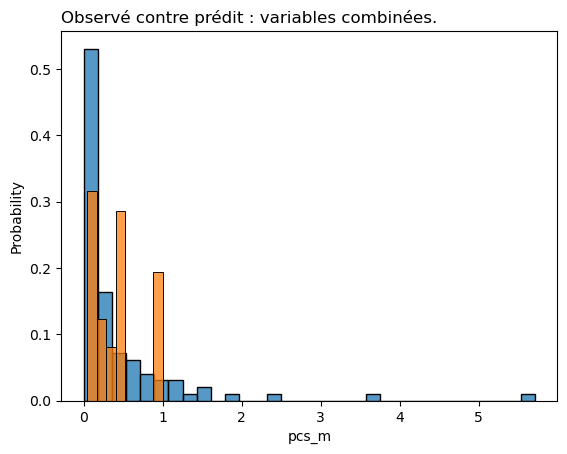

In [31]:
observed = t_and_f[t_and_f.code == code_of_interest].copy()
predicted = results['predictions']

fig, ax = plt.subplots()

title="Observé contre prédit : variables combinées."

sns.histplot(data=observed, x='pcs_m', ax=ax, stat='probability')
sns.histplot(data=predicted, x=predicted, ax=ax, stat='probability')
ax.set_title(title, loc='left')
plt.show()

In [32]:
results['summary']

,result
Method,IRLS
Observations,98
Pseudo R squared,0.152709
Log-Likelihood,-75.971103
Pearson chi2,43.256273
Deviance,32.945439


In [33]:
results['params']

,p value,coefficients
Intercept,0.996546,-0.011053
frequentation,0.710404,0.188602
situation,0.068985,0.801159
distance,0.286442,-1.324314
substrat,0.080942,-0.836151


In [34]:
no_combined.rename(columns={'fréquentation':'frequentation'}, inplace=True)

resultsx = apply_glm_with_statsmodels(no_combined, target_variable, predictor_variables, code_of_interest, family)

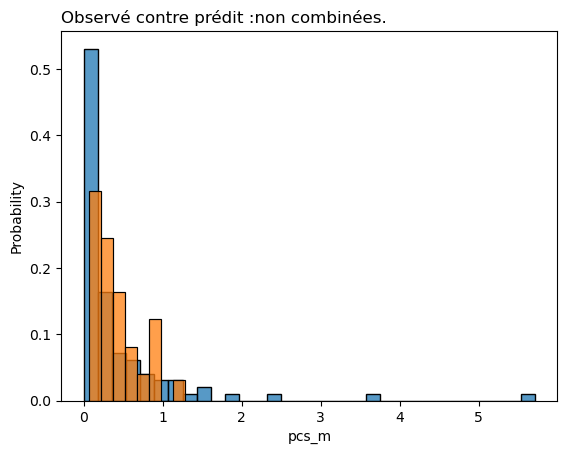

In [35]:
observed = no_combined[no_combined.code == code_of_interest].copy()
predicted = resultsx['predictions']

fig, ax = plt.subplots()

title="Observé contre prédit :non combinées."

sns.histplot(data=observed, x='pcs_m', ax=ax, stat='probability')
sns.histplot(data=predicted, x=predicted, ax=ax, stat='probability')
ax.set_title(title, loc='left')
plt.show()

In [36]:
resultsx['summary']

,result
Method,IRLS
Observations,98
Pseudo R squared,0.143506
Log-Likelihood,-76.500471
Pearson chi2,46.792528
Deviance,34.004177


In [37]:
resultsx['params']

,p value,coefficients
Intercept,0.144534,-2.051350
frequentation,0.241732,0.447006
situation,0.072975,0.768736
distance,0.344068,-0.306972
substrat,0.159711,-0.272161


## Perspectives 2024.

## Inventaire Plastock.

In [38]:
t = rc.translate_for_display(tiii.inventory, amap=language_maps['fr'], lan='fr')
t['objet'] = t.code.apply(lambda x: codes.loc[x, 'fr'])
t = t[[t.columns[0], t.columns[-1], *t.columns[1:-1]]]
t.set_index(['code', 'objet'], inplace=True)
t.index.name = None
t.style.set_table_styles(conf_.table_css_styles).format(**conf_.format_kwargs)

,,quantité,% du total,pcs/m,taux d'échec
code,objet,,,,
Gfrags,"Fragments de plastique: G80, G79, G78, G75",11'221,"0,41","0,72","0,97"
G27,Mégots et filtres à cigarettes,3'089,"0,11","0,15","0,79"
G30,"Emballages de bonbons, de snacks",2'080,"0,08","0,15","0,74"
G106,Fragments de plastique angulaires <5mm,1'926,"0,07","0,00","0,41"
G112,Pellets industriels (GPI),1'526,"0,06","0,00","0,36"
Gfoams,"Fragments de polystyrène expansé: G76, G81, G82, G83",1'399,"0,05","0,07","0,72"
Gcaps,"Couvercles en plastique bouteille: G21, G22, G23, G24",1'070,"0,04","0,04","0,65"
G95,Coton-tige,1'040,"0,04","0,03","0,54"
G74,Mousse de plastique pour l'isolation thermique,406,"0,01","0,00","0,38"


In [39]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: dec4

seaborn    : 0.12.2
matplotlib : 3.7.1
numpy      : 1.24.2
pandas     : 2.0.0
statsmodels: 0.13.5

